In [1]:
%matplotlib inline


# Feature discretization

A demonstration of feature discretization on synthetic classification datasets.
Feature discretization decomposes each feature into a set of bins, here equally
distributed in width. The discrete values are then one-hot encoded, and given
to a linear classifier. This preprocessing enables a non-linear behavior even
though the classifier is linear.

On this example, the first two rows represent linearly non-separable datasets
(moons and concentric circles) while the third is approximately linearly
separable. On the two linearly non-separable datasets, feature discretization
largely increases the performance of linear classifiers. On the linearly
separable dataset, feature discretization decreases the performance of linear
classifiers. Two non-linear classifiers are also shown for comparison.

This example should be taken with a grain of salt, as the intuition conveyed
does not necessarily carry over to real datasets. Particularly in
high-dimensional spaces, data can more easily be separated linearly. Moreover,
using feature discretization and one-hot encoding increases the number of
features, which easily lead to overfitting when the number of samples is small.

The plots show training points in solid colors and testing points
semi-transparent. The lower right shows the classification accuracy on the test
set.



dataset 0
---------
LogisticRegression: 0.86
LinearSVC: 0.86
KBinsDiscretizer + LogisticRegression: 0.86
KBinsDiscretizer + LinearSVC: 0.94
GradientBoostingClassifier: 0.90
SVC: 0.94

dataset 1
---------
LogisticRegression: 0.40
LinearSVC: 0.40
KBinsDiscretizer + LogisticRegression: 0.78
KBinsDiscretizer + LinearSVC: 0.80
GradientBoostingClassifier: 0.84
SVC: 0.84

dataset 2
---------
LogisticRegression: 0.98
LinearSVC: 0.96
KBinsDiscretizer + LogisticRegression: 0.94
KBinsDiscretizer + LinearSVC: 0.94
GradientBoostingClassifier: 0.94
SVC: 0.98


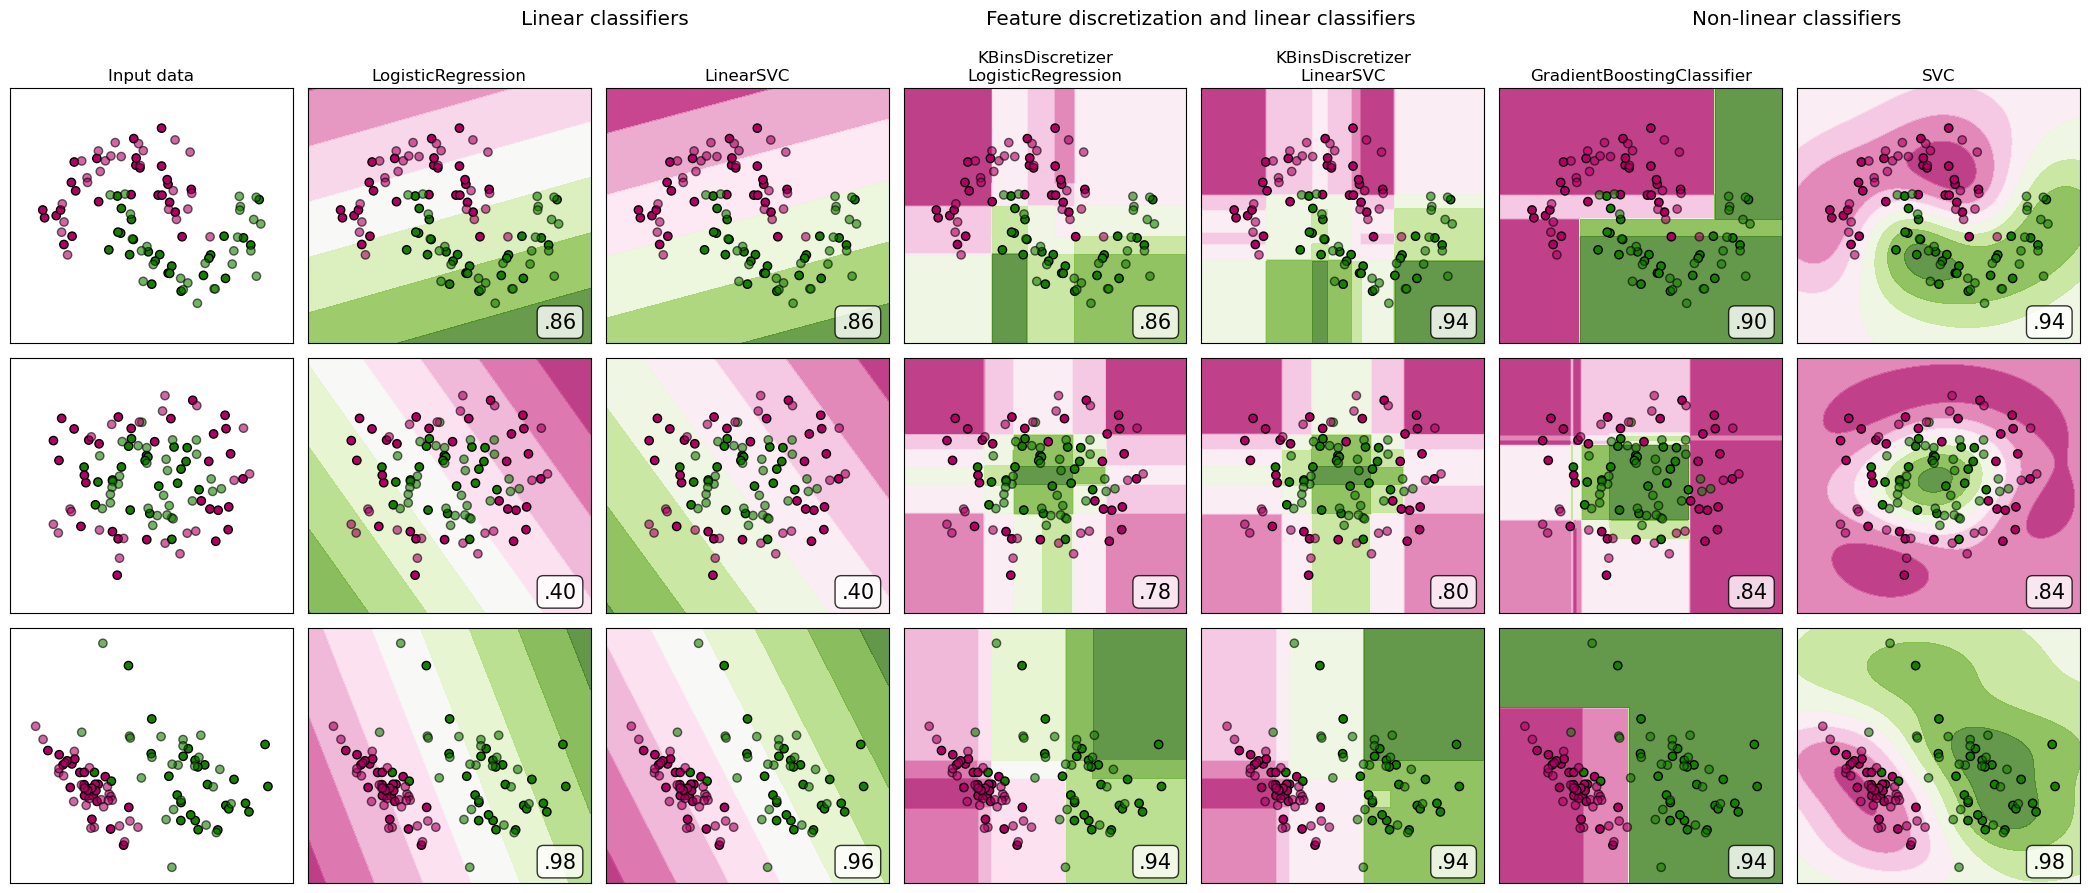

In [2]:
# Code source: Tom Dupré la Tour
# Adapted from plot_classifier_comparison by Gaël Varoquaux and Andreas Müller
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

h = 0.02  # step size in the mesh


def get_name(estimator):
    name = estimator.__class__.__name__
    if name == "Pipeline":
        name = [get_name(est[1]) for est in estimator.steps]
        name = " + ".join(name)
    return name


# list of (estimator, param_grid), where param_grid is used in GridSearchCV
# The parameter spaces in this example are limited to a narrow band to reduce
# its runtime. In a real use case, a broader search space for the algorithms
# should be used.
classifiers = [
    (
        make_pipeline(StandardScaler(), LogisticRegression(random_state=0)),
        {"logisticregression__C": np.logspace(-1, 1, 3)},
    ),
    (
        make_pipeline(StandardScaler(), LinearSVC(random_state=0)),
        {"linearsvc__C": np.logspace(-1, 1, 3)},
    ),
    (
        make_pipeline(
            StandardScaler(),
            KBinsDiscretizer(encode="onehot"),
            LogisticRegression(random_state=0),
        ),
        {
            "kbinsdiscretizer__n_bins": np.arange(5, 8),
            "logisticregression__C": np.logspace(-1, 1, 3),
        },
    ),
    (
        make_pipeline(
            StandardScaler(),
            KBinsDiscretizer(encode="onehot"),
            LinearSVC(random_state=0),
        ),
        {
            "kbinsdiscretizer__n_bins": np.arange(5, 8),
            "linearsvc__C": np.logspace(-1, 1, 3),
        },
    ),
    (
        make_pipeline(
            StandardScaler(), GradientBoostingClassifier(n_estimators=5, random_state=0)
        ),
        {"gradientboostingclassifier__learning_rate": np.logspace(-2, 0, 5)},
    ),
    (
        make_pipeline(StandardScaler(), SVC(random_state=0)),
        {"svc__C": np.logspace(-1, 1, 3)},
    ),
]

names = [get_name(e).replace("StandardScaler + ", "") for e, _ in classifiers]

n_samples = 100
datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_classification(
        n_samples=n_samples,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        random_state=2,
        n_clusters_per_class=1,
    ),
]

fig, axes = plt.subplots(
    nrows=len(datasets), ncols=len(classifiers) + 1, figsize=(21, 9)
)

cm_piyg = plt.cm.PiYG
cm_bright = ListedColormap(["#b30065", "#178000"])

# iterate over datasets
for ds_cnt, (X, y) in enumerate(datasets):
    print(f"\ndataset {ds_cnt}\n---------")

    # split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42
    )

    # create the grid for background colors
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # plot the dataset first
    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    # plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # and testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    # iterate over classifiers
    for est_idx, (name, (estimator, param_grid)) in enumerate(zip(names, classifiers)):
        ax = axes[ds_cnt, est_idx + 1]

        clf = GridSearchCV(estimator=estimator, param_grid=param_grid)
        with ignore_warnings(category=ConvergenceWarning):
            clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print(f"{name}: {score:.2f}")

        # plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]*[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
        else:
            Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm_piyg, alpha=0.8)

        # plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # and testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())

        if ds_cnt == 0:
            ax.set_title(name.replace(" + ", "\n"))
        ax.text(
            0.95,
            0.06,
            (f"{score:.2f}").lstrip("0"),
            size=15,
            bbox=dict(boxstyle="round", alpha=0.8, facecolor="white"),
            transform=ax.transAxes,
            horizontalalignment="right",
        )


plt.tight_layout()

# Add suptitles above the figure
plt.subplots_adjust(top=0.90)
suptitles = [
    "Linear classifiers",
    "Feature discretization and linear classifiers",
    "Non-linear classifiers",
]
for i, suptitle in zip([1, 3, 5], suptitles):
    ax = axes[0, i]
    ax.text(
        1.05,
        1.25,
        suptitle,
        transform=ax.transAxes,
        horizontalalignment="center",
        size="x-large",
    )
plt.show()